In [1]:
%matplotlib inline

import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy import interpolate
from scipy import stats
from scipy import signal
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable

from functools import reduce # only in Python 3

from analysis.plots.utils import get_colors
from analysis.processing.utils import get_sessions_list, create_symlinks, get_params_from_json
from analysis.processing.metrics import get_fields_between_epochs, get_lonely_fields
from analysis.adapters.hdf5 import H5NAMES

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Get sessions

In [3]:
def is_12(sessionpath):
    conf = get_params_from_json(sessionpath)['vr']['scene']
    
    return conf['gain'] < 0.3

In [4]:
COLORS = get_colors()

source = '/home/andrey/storage2/andrey/data/processed'
assets = '/home/andrey/storage2/andrey/data/projects/22_VFG/assets'
paper = '/home/andrey/storage2/andrey/data/projects/24_shift/PAPER'
bad_clu_dir = '/home/andrey/storage2/andrey/data/projects/24_shift/bad_clusters'

animals = ['005363', '005364']  # last four, add '003908', '003909'
animals = ['003908', '003909', '005363', '005364']  # last four, add '003908', '003909'

sessions_12 = list(get_sessions_list(source, animals, 'GAIN 3 parts 1.2x'))
sessions_14 = list(get_sessions_list(source, animals, 'GAIN 3 parts 1.4x'))

print('Found %s 1.2x sessions, %s 1.4x sessions' % (len(sessions_12), len(sessions_14)))

Found 30 1.2x sessions, 24 1.4x sessions


In [5]:
# visual shift for comparison
animals_vs = ['00908', '00910', '002784', '003281', '003282', '003908', '003909', '005363', '005364']
s_list_l = get_sessions_list(source, animals_vs, 'SHIFT visual')
s_list_d = get_sessions_list(source, animals_vs, 'SHIFT visual +dark')
s_list_long = get_sessions_list(source, animals_vs, 'SHIFT visual long +dark')

s_list_all = list(s_list_l) + list(s_list_d)

shift_AB_s = get_fields_between_epochs(source, s_list_all, 'A', 'B')
shift_AB_l = get_fields_between_epochs(source, s_list_long, 'A', 'B')

PF match found for 420 fields from total 801 A and 831 B fields
PF match found for 288 fields from total 516 A and 527 B fields


In [6]:
# or a single session
# sessions = [
#     ['003282', '2019-11-06_22-36-07', 'GAIN 3 parts'],
#     ['003282', '2019-11-18_10-35-43', 'GAIN 3 parts'],
# ]

shift_A_B_12 = get_fields_between_epochs(source, sessions_12, 'A', 'B')
shift_A_B_14 = get_fields_between_epochs(source, sessions_14, 'A', 'B')
shift_B_C_12 = get_fields_between_epochs(source, sessions_12, 'B', 'C')
shift_B_C_14 = get_fields_between_epochs(source, sessions_14, 'B', 'C')
shift_C_D_12 = get_fields_between_epochs(source, sessions_12, 'C', 'D')
shift_C_D_14 = get_fields_between_epochs(source, sessions_14, 'C', 'D')
shift_A_D_12 = get_fields_between_epochs(source, sessions_12, 'A', 'D')
shift_A_D_14 = get_fields_between_epochs(source, sessions_14, 'A', 'D')
shift_A_C_12 = get_fields_between_epochs(source, sessions_12, 'A', 'C')
shift_A_C_14 = get_fields_between_epochs(source, sessions_14, 'A', 'C')

PF match found for 574 fields from total 1080 A and 1030 B fields
PF match found for 341 fields from total 657 A and 623 B fields
PF match found for 599 fields from total 1030 B and 1010 C fields
PF match found for 357 fields from total 623 B and 624 C fields
PF match found for 543 fields from total 1006 C and 1018 D fields
PF match found for 320 fields from total 574 C and 548 D fields
PF match found for 491 fields from total 1078 A and 1018 D fields
PF match found for 261 fields from total 602 A and 548 D fields
PF match found for 523 fields from total 1080 A and 1010 C fields
PF match found for 314 fields from total 657 A and 624 C fields


In [7]:
# lonely fields
lonely_A_B_12 = pd.concat([get_lonely_fields(source, rec[0], rec[1], 'A', 'B') for rec in sessions_12])
lonely_A_B_14 = pd.concat([get_lonely_fields(source, rec[0], rec[1], 'A', 'B') for rec in sessions_14])
lonely_A_C_12 = pd.concat([get_lonely_fields(source, rec[0], rec[1], 'A', 'C') for rec in sessions_12])
lonely_A_C_14 = pd.concat([get_lonely_fields(source, rec[0], rec[1], 'A', 'C') for rec in sessions_14])
lonely_A_D_12 = pd.concat([get_lonely_fields(source, rec[0], rec[1], 'A', 'D') for rec in sessions_12])
lonely_A_D_14 = pd.concat([get_lonely_fields(source, rec[0], rec[1], 'A', 'D') for rec in sessions_14])

In [8]:
print(list(shift_A_B_12))

['animal', 'session', 'electrode', 'unit', 'field_A', 'field_B', 'overlap_norm', 'sic_A', 'sic_B', 'isol_dist', 'peak_FR_A', 'peak_FR_B', 'COMa_x', 'COMa_y', 'COMb_x', 'COMb_y', 'shift', 'size_A', 'size_B']


## Field sizes

In [37]:
df = shift_A_C_12[get_filtered_idxs(shift_A_C_12)]
delta = 0.075

df_00 = df[(df['shift'] > -delta) & (df['shift'] < delta)]
df_15 = df[(df['shift'] > 0.15 - delta) & (df['shift'] < 0.15 + delta)]
df_30 = df[(df['shift'] > 0.30 - delta) & (df['shift'] < 0.30 + delta)]
df_   = df[(df['shift'] < -delta) | (df['shift'] > 0.3 + delta)]
df_in = df[(df['shift'] > -delta) & (df['shift'] < 0.3 + delta)]

collected = []
bins = np.linspace(-0.8, 0.8, 15)
for i, dfx in enumerate([df_00, df_15, df_30]):
    size_avg = []
    for j, bin_n in enumerate(bins[:-1]):
        sel_A = dfx[(dfx['COMa_y'] > bins[j]) & (dfx['COMa_y'] < bins[j+1])]
        #sel_B = dfx[(dfx['COMb_y'] > bins[j]) & (dfx['COMb_y'] < bins[j+1])]
        #size_avg.append( (sel_A['size_A'].mean() + sel_B['size_B'].mean())/2 )
        size_avg.append(sel_A['size_A'].mean())

    collected.append(size_avg)

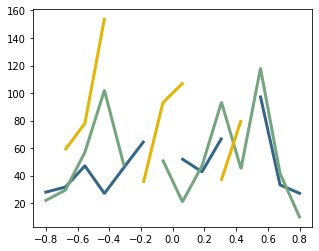

In [38]:
fig = figure(figsize=(5, 4))

ax = fig.add_subplot(111)
clrs = ('a', 'c', 'd')
kernel_1D = signal.gaussian(100, std=15)
for i, sizes in enumerate(collected):
    x_new = np.linspace(-0.8, 0.8, 600)
    f = interpolate.interp1d(np.linspace(-0.8, 0.8, len(sizes)), sizes)
    y_new = np.convolve(f(x_new), kernel_1D, 'same') / kernel_1D.sum()
    #a_BSpline = interpolate.make_interp_spline(np.linspace(0, 0.8, len(sizes)), sizes)
    #y_new = a_BSpline(x_new)
    ax.plot(x_new, f(x_new), color=COLORS[clrs[i]], lw=3)

# Filters

## Bad fields

- information content > 0.2
- firing rate > 1.5Hz
- isolation distance > 15

In [38]:
def get_filtered_idxs(dataset):
    sic, pfr, iso = 0.2, 1.5, 15    # peak firing rate > 1.5 Hz, isolation distance > 15
    #sic, pfr, iso = 0.3, 2, 20    # peak firing rate > 1.5 Hz, isolation distance > 15
    idxs_sic = (dataset['sic_A'] > sic) & (dataset['sic_B'] > sic)
    idxs_pfr = (dataset['peak_FR_A'] > pfr) & (dataset['peak_FR_B'] > pfr)
    idxs_iso = (dataset['isol_dist'] > iso)
    return idxs_sic & idxs_pfr & idxs_iso

In [39]:
def get_idxs_of_good_clu(ds):
    col_types = {'animal': str, 'session': str, 'electrode': int, 'unit': int}
    bad_clu = pd.read_csv(os.path.join(bad_clu_dir, 'all.csv'), dtype=col_types)
    
    all_idxs = np.array(ds.index.tolist())
    df = ds.copy()
    df['idxs'] = all_idxs
    
    bad_idxs = np.array(df.merge(bad_clu, on=['animal', 'session', 'electrode', 'unit'], how='inner')['idxs'])
    return np.isin(all_idxs, bad_idxs, invert=True)

# ANALYSIS

## Example cell

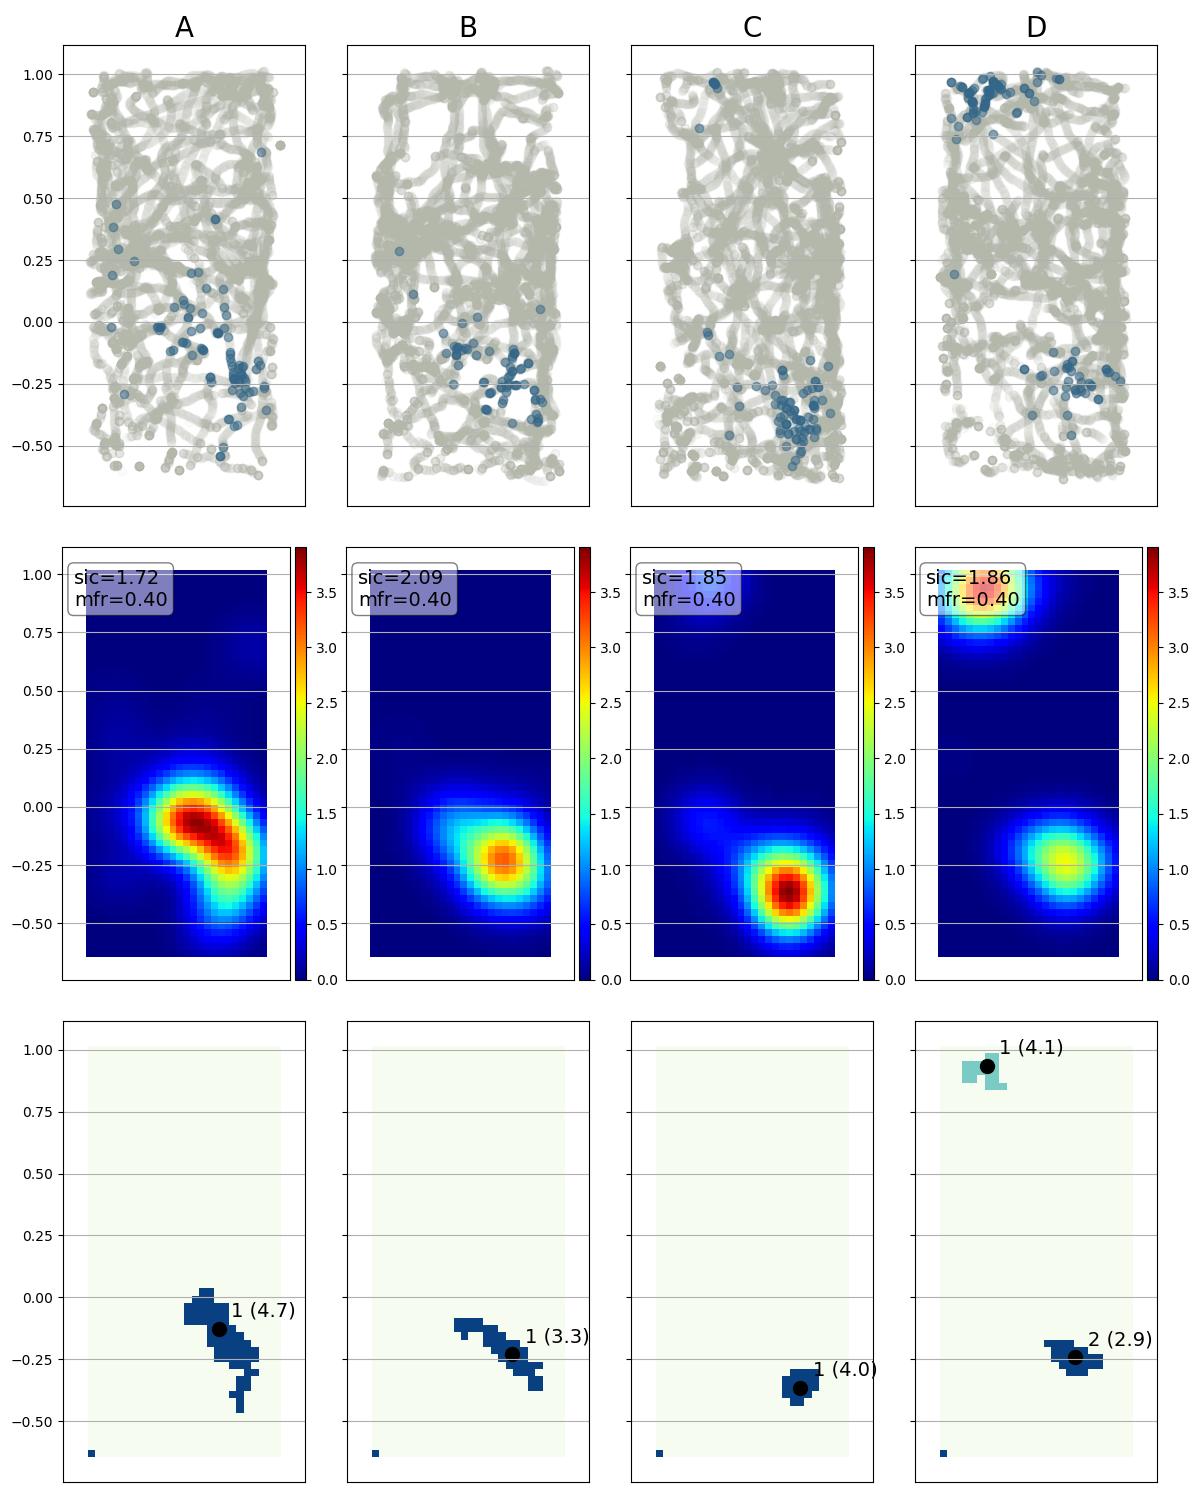

In [119]:
from IPython.display import Image

example = os.path.join(source, '005363', '2020-10-13_21-28-55', 'analysis', 'bootstrapped', '005363_2020-10-13_21-28-55_2_6.png')
Image(filename = example, width=600)

# for the 1.4x
# 005363_2020-10-10_20-45-48_3_4

## Shift histogram A (no gain) - B (gain) - C (shifted)

In [11]:
def plot_hist(ax, data, shift_act, plot_median=True):
    bins = np.arange(-0.4, 0.6, 0.03)
    ax.set_xlim(-0.4, 0.7)
    ax.hist(data, bins=bins, color=COLORS['a'], ec='black')
    ax.axvline(0, color=COLORS['b'])
    ax.axvline(shift_act, color=COLORS['b'], ls='--')

    if not plot_median:
        return
    
    tt_stat_CD, tt_pval_CD = stats.ttest_1samp(data, 0.0)
    hist_max = np.histogram(data, bins)[0].max()
    y_pos = ax.get_ylim()[1]
    x_pos = ax.get_xlim()[0] + 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0])

    ax.axvline(np.median(data), ls='--', color=COLORS['b'])
    ax.text(x_pos, 0.9 * y_pos, 'n = %d' % len(data), fontsize=14)
    ax.text(x_pos, 0.8 * y_pos, 'med = %.2f' % np.median(data), fontsize=14)
    ax.text(x_pos, 0.7 * y_pos, 't(%s) = %.3f' % (len(data), tt_stat_CD), fontsize=14)
    ax.text(x_pos, 0.6 * y_pos, 'p-val = %.3f' % tt_pval_CD, fontsize=14)

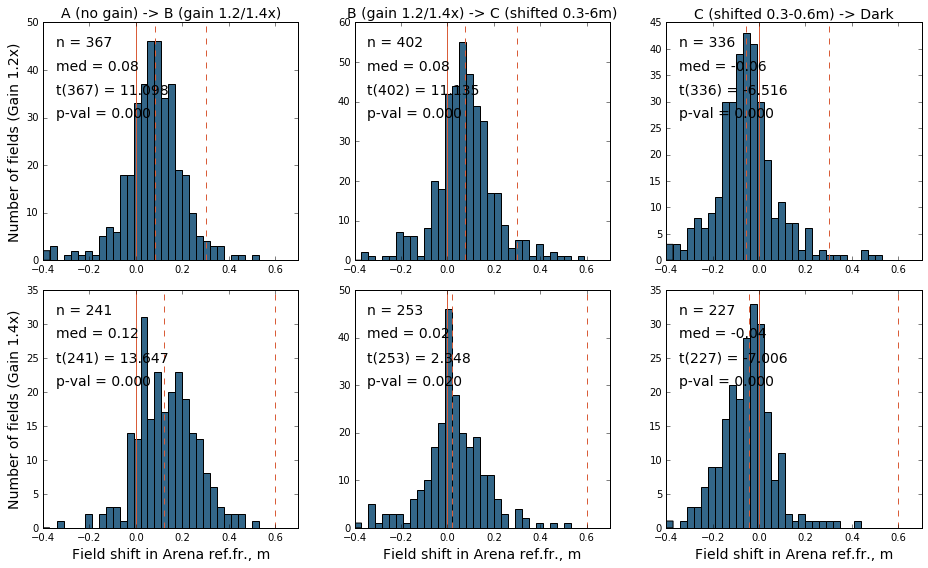

In [13]:
gspec = gridspec.GridSpec(ncols=3, nrows=2)
fig = figure(figsize=(13, 8))
x_lim_l = -0.4
x_lim_r =  0.7

# Gain 1.2x
ax = fig.add_subplot(gspec[0, 0])
ax.set_ylabel('Number of fields (Gain 1.2x)', fontsize=14)
ax.set_title("A (no gain) -> B (gain 1.2/1.4x)", fontsize=14)
plot_hist(ax, (-1) * np.array(shift_A_B_12[get_filtered_idxs(shift_A_B_12)]['shift']), 0.3)
ax = fig.add_subplot(gspec[0, 1])
ax.set_title("B (gain 1.2/1.4x) -> C (shifted 0.3-6m)", fontsize=14)
plot_hist(ax, (-1) * np.array(shift_B_C_12[get_filtered_idxs(shift_B_C_12)]['shift']), 0.3)
ax = fig.add_subplot(gspec[0, 2])
ax.set_title("C (shifted 0.3-0.6m) -> Dark", fontsize=14)
plot_hist(ax, (-1) * np.array(shift_C_D_12[get_filtered_idxs(shift_C_D_12)]['shift']), 0.3)
#ax = fig.add_subplot(gspec[0, 3])
#plot_hist(ax, (-1) * np.array(shift_A_D_12[get_filtered_idxs(shift_A_D_12)]['shift']), 25)

# Gain 1.4x
ax = fig.add_subplot(gspec[1, 0])
ax.set_ylabel('Number of fields (Gain 1.4x)', fontsize=14)
ax.set_xlabel('Field shift in Arena ref.fr., m', fontsize=14)
plot_hist(ax, (-1) * np.array(shift_A_B_14[get_filtered_idxs(shift_A_B_14)]['shift']), 0.6)
ax = fig.add_subplot(gspec[1, 1])
ax.set_xlabel('Field shift in Arena ref.fr., m', fontsize=14)
plot_hist(ax, (-1) * np.array(shift_B_C_14[get_filtered_idxs(shift_B_C_14)]['shift']), 0.6)
ax = fig.add_subplot(gspec[1, 2])
ax.set_xlabel('Field shift in Arena ref.fr., m', fontsize=14)
plot_hist(ax, (-1) * np.array(shift_C_D_14[get_filtered_idxs(shift_C_D_14)]['shift']), 0.6)
#ax = fig.add_subplot(gspec[1, 3])
#plot_hist(ax, (-1) * np.array(shift_A_D_15[get_filtered_idxs(shift_A_D_15)]['shift']), 24)

fig.tight_layout()
filename = "04-vGAIN_shift_hist_ABC.png"
fig.savefig(os.path.join(os.path.join(paper), filename))

In [11]:
datasets = []

for ds in (shift_AB_s, shift_AB_l, shift_A_C_12, shift_A_C_14):
    df_vs = ds.copy()
    df_vs['shift'] = (-1) * (df_vs['shift'])
    df_vs = df_vs[get_idxs_of_good_clu(df_vs)]
    df_vs = df_vs[get_filtered_idxs(df_vs)]
    datasets.append(df_vs)

0.19576295864880605 0.00022472965169628711
0.5438954675377705 2.238233504815807e-22


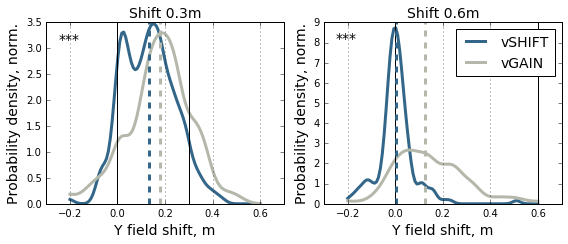

In [21]:
bins = np.arange(-0.4, 0.6, 0.025)
fig = figure(figsize=(8, 3.5))
titles = ['Shift 0.3m', 'Shift 0.6m']
t_heights = [3.1, 8]

for i in range(2):
    ax = fig.add_subplot(1, 2, i+1)
    ax.set_xlim(-0.3, 0.7)

    ker_v = stats.gaussian_kde(datasets[i]['shift'], bw_method=0.2)
    ker_g = stats.gaussian_kde(datasets[i+2]['shift'], bw_method=0.2)
    x_vals = np.linspace(-0.2, 0.6, 100)
    ax.plot(x_vals, ker_v(x_vals), color=COLORS['a'], lw=3, ls='-', label='vSHIFT')
    ax.plot(x_vals, ker_g(x_vals), color=COLORS['f'], lw=3, ls='-', label='vGAIN')
    ax.axvline(0, color='black')
    ax.axvline((i+1)*0.3, color='black')
    ax.axvline(np.median(np.array(datasets[i]['shift'])), color=COLORS['a'], lw=3, ls='--')
    ax.axvline(np.median(np.array(datasets[i+2]['shift'])), color=COLORS['f'], lw=3, ls='--')
    ax.xaxis.grid()
    ax.set_xlabel('Y field shift, m', fontsize=14)
    ax.set_ylabel('Probability density, norm.', fontsize=14)
    ax.set_title(titles[i], fontsize=14)
    ax.text(-0.25, t_heights[i], '***', fontsize=14)
    if i > 0:
        ax.legend(loc='upper right', fontsize=14)

    st, pval = stats.ks_2samp(datasets[i]['shift'], datasets[i+2]['shift'])
    print(st, pval)



fig.tight_layout()
filename = "4d.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename))

### split arena in halfs

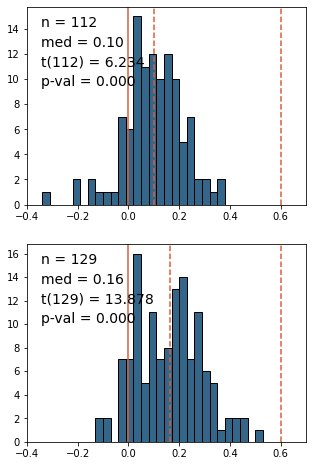

In [295]:
d1 = shift_A_B_14[get_filtered_idxs(shift_A_B_14)]
#d1 = shift_A_B_12[get_filtered_idxs(shift_A_B_12)]
d1s = d1[d1['COMa_y'] < 0]
d1n = d1[d1['COMa_y'] > 0]

fig = figure(figsize=(5, 8))
ax = fig.add_subplot(2, 1, 1)
plot_hist(ax, (-1) * np.array(d1s['shift']), 0.6)
ax = fig.add_subplot(2, 1, 2)
plot_hist(ax, (-1) * np.array(d1n['shift']), 0.6)

## Overall shift (to compare with vSHIFT) via gain A-C, original vs dark A-D

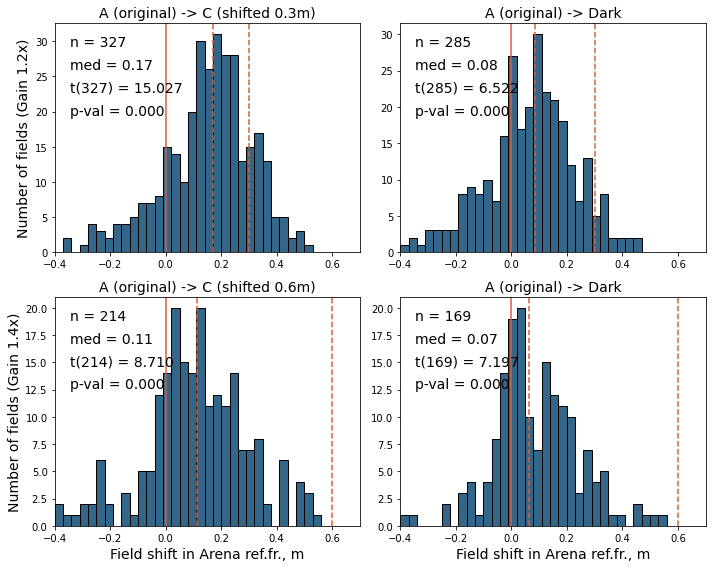

In [257]:
gspec = gridspec.GridSpec(ncols=2, nrows=2)
fig = figure(figsize=(10, 8))
x_lim_l = -0.4
x_lim_r =  0.7

# Gain 1.2x
ax = fig.add_subplot(gspec[0, 0])
ax.set_ylabel('Number of fields (Gain 1.2x)', fontsize=14)
ax.set_title("A (original) -> C (shifted 0.3m)", fontsize=14)
plot_hist(ax, (-1) * np.array(shift_A_C_12[get_filtered_idxs(shift_A_C_12)]['shift']), 0.3, True)
ax = fig.add_subplot(gspec[0, 1])
ax.set_title("A (original) -> Dark", fontsize=14)
plot_hist(ax, (-1) * np.array(shift_A_D_12[get_filtered_idxs(shift_A_D_12)]['shift']), 0.3, True)

# Gain 1.4x
ax = fig.add_subplot(gspec[1, 0])
ax.set_ylabel('Number of fields (Gain 1.4x)', fontsize=14)
ax.set_title("A (original) -> C (shifted 0.6m)", fontsize=14)
ax.set_xlabel('Field shift in Arena ref.fr., m', fontsize=14)
plot_hist(ax, (-1) * np.array(shift_A_C_14[get_filtered_idxs(shift_A_C_14)]['shift']), 0.6, True)
ax = fig.add_subplot(gspec[1, 1])
ax.set_title("A (original) -> Dark", fontsize=14)
ax.set_xlabel('Field shift in Arena ref.fr., m', fontsize=14)
plot_hist(ax, (-1) * np.array(shift_A_D_14[get_filtered_idxs(shift_A_D_14)]['shift']), 0.6, True)


fig.tight_layout()
filename = "04-vGAIN_shift_hist_ACD.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

### remapping

In [44]:
data = []

# remapping A -> B
df1 = lonely_A_B_12[lonely_A_B_12['cond'] == 'A']
dfl_AB12 = df1[(df1['sic'] > 0.15) & (df1['isol_dist'] > 20) & (df1['peak_FR'] > 1.5)]
df2 = lonely_A_B_14[lonely_A_B_14['cond'] == 'A']
dfl_AB14 = df2[(df2['sic'] > 0.15) & (df2['isol_dist'] > 20) & (df2['peak_FR'] > 1.5)]

dfa_AB12 = shift_A_B_12[get_filtered_idxs(shift_A_B_12)]
dfa_AB14 = shift_A_B_14[get_filtered_idxs(shift_A_B_14)]

data = [[len(dfa_AB12), len(dfl_AB12)], [len(dfa_AB14), len(dfl_AB14)]]

# remapping A -> C
df1 = lonely_A_C_12[lonely_A_C_12['cond'] == 'A']
dfl_AC12 = df1[(df1['sic'] > 0.15) & (df1['isol_dist'] > 20) & (df1['peak_FR'] > 1.5)]
df2 = lonely_A_C_14[lonely_A_C_14['cond'] == 'A']
dfl_AC14 = df2[(df2['sic'] > 0.15) & (df2['isol_dist'] > 20) & (df2['peak_FR'] > 1.5)]

dfa_AC12 = shift_A_C_12[get_filtered_idxs(shift_A_C_12)]
dfa_AC14 = shift_A_C_14[get_filtered_idxs(shift_A_C_14)]

data += [[len(dfa_AC12), len(dfl_AC12)], [len(dfa_AC14), len(dfl_AC14)]]
data[1], data[2] = data[2], data[1]  # swap to plot short first

data = np.array(data)
# total/lonely: A->B 12, A->B 14, A->C 12, A->C 14
data

array([[367,  98],
       [327, 126],
       [241,  64],
       [214,  76]])

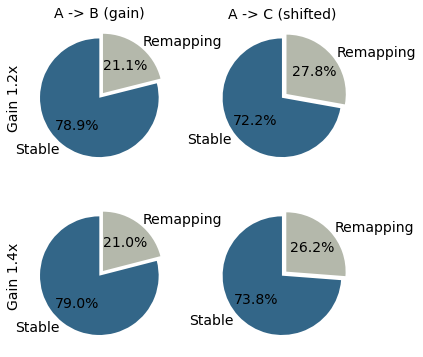

In [45]:
fig = figure(figsize=(6, 6))
labels = ['Stable', 'Remapping']
colors = [COLORS['a'], COLORS['f']]
explode = (0, 0.1)
titles = ['A -> B (gain)', 'A -> C (shifted)']
y_labels = ['Gain 1.2x', 'Gain 1.4x']

for i, rem_data in enumerate(data):
    ax = fig.add_subplot(2, 2, i+1)
    wedges, lbls, autopct = ax.pie(rem_data, explode=explode, colors=colors, labels=labels, \
                 autopct='%1.1f%%', textprops={'fontsize': 14}, startangle=90)
    for lab in lbls:
        lab.set_fontsize(14)
    if i < 2:
        ax.set_title(titles[i], fontsize=14)
    if i % 2 == 0:
        ax.set_ylabel(y_labels[int(i/2)], fontsize=14)

### Distribution of lonely fields within the arena

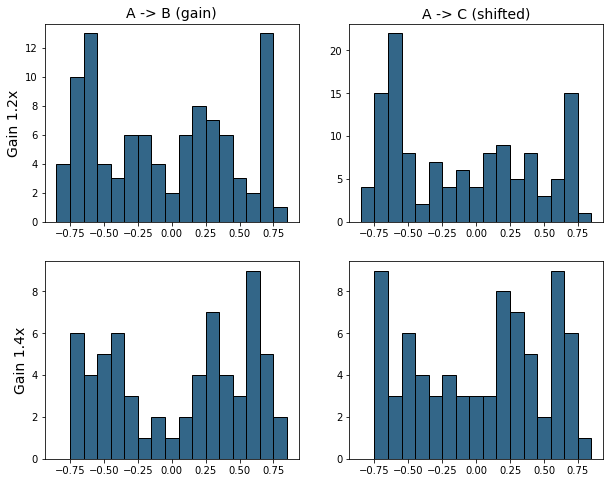

In [54]:
fig = figure(figsize=(10, 8))
bins = np.arange(-0.85, 0.9, 0.1)
titles = ['A -> B (gain)', 'A -> C (shifted)']
y_labels = ['Gain 1.2x', 'Gain 1.4x']

for i, lonely in enumerate([dfl_AB12, dfl_AC12, dfl_AB14, dfl_AC14]):
    ax = fig.add_subplot(2, 2, i+1)
    ax.hist(lonely['COMa_y'], bins=bins, color=COLORS['a'], ec='black')
    if i < 2:
        ax.set_title(titles[i], fontsize=14)
    if i % 2 == 0:
        ax.set_ylabel(y_labels[int(i/2)], fontsize=14)        

## Shift along the arena

The larger mismatch between reference frames at Gain 1.4x resembles the Knight, Jeffery 2014 (Figure 4).

In [83]:
def plot_shifts(ax, dataset, ideal_slope, plot_regress=False):
    #idxs = get_filtered_idxs(dataset)
    df = dataset.copy()
    df = df[get_idxs_of_good_clu(df)]
    df = df[get_filtered_idxs(df)]

    x = np.array(df['COMa_y'])
    y = (-1) * np.array(df['shift'])
    x_min, x_max = x.min(), x.max()

    # linear approx shift
    l_b, r_b = 0.22, 0.52
    x_sel = np.array(df[(df['COMa_y'] > l_b) & (df['COMa_y'] < r_b)]['COMa_y'])
    y_sel = (-1) * np.array(df[(df['COMa_y'] > l_b) & (df['COMa_y'] < r_b)]['shift'])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_sel, y_sel)

    ax.grid()
    #ax.set_ylim(-0.2, ideal_slope + 0.1)
    ax.set_xlim(-0.9, 0.9)
    ax.axhline(0.0, color=COLORS['b'])
    #ax.axhline(ideal_slope, color=COLORS['b'])
    #ax.set_xlabel('Position in Arena, m', fontsize=14)

    ax.plot([x_min, x_max], [0, ideal_slope], ls='--', color=COLORS['b'])
    ax.plot([x_min, x_max], [0, ideal_slope/2], ls='--', color=COLORS['b'])
    
    ax.annotate('100%', (x_max + 0.01, ideal_slope + 0.01), fontsize=14)
    ax.annotate('50%', (x_max + 0.01, ideal_slope/2 + 0.01), fontsize=14)

    if plot_regress:
        ax.plot(x_sel, intercept + slope * x_sel, lw=3, ls='-', color=COLORS['b'])
        ax.annotate('%.2f' % slope, (l_b + 0.01, 0.65), fontsize=14)
        
    if ideal_slope > 0.5:
        l_b, r_b = -0.29, -0.14
        x_sel = np.array(df[(df['COMa_y'] > l_b) & (df['COMa_y'] < r_b)]['COMa_y'])
        y_sel = (-1) * np.array(df[(df['COMa_y'] > l_b) & (df['COMa_y'] < r_b)]['shift'])
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_sel, y_sel)        
        ax.plot(x_sel, intercept + slope * x_sel, lw=3, ls='-', color=COLORS['b'])
        ax.annotate('%.2f' % slope, (l_b + 0.01, 0.65), fontsize=14)
    
    ax.scatter(x, y, color=COLORS['a'], alpha=0.5)

In [35]:
# mean occupancy for all gain sessions
data_12 = shift_A_B_12[get_filtered_idxs(shift_A_B_12)][['animal','session']].drop_duplicates()
data_14 = shift_A_B_14[get_filtered_idxs(shift_A_B_14)][['animal','session']].drop_duplicates()
cond_A = 'A'
cond_B = 'B'

x_min, x_max = -0.4, 0.4
y_min, y_max = -0.85, 0.85
x_range = x_max - x_min
y_range = y_max - y_min
y_bin_count = int(np.ceil(y_range / 0.025))
x_bin_count = int(np.ceil(x_range / 0.025))
pos_range = np.array([[x_min, x_max], [y_min, y_max]])

occup_means_12 = []
occup_means_14 = []
for j, data in enumerate([data_12, data_14]):
    for i, row in data.iterrows():
        h5_path = os.path.join(source, row['animal'], row['session'], '%s.h5' % H5NAMES.filebase)
        with h5py.File(h5_path, 'r') as f:
            traj = np.array(f['animal_trajectory'])
            idxs_A = np.array(f['%s_idxs' % cond_A])
            idxs_B = np.array(f['%s_idxs' % cond_B])

            pos_A_x = traj[idxs_A][:, 1]
            pos_A_y = traj[idxs_A][:, 2]
            pos_B_x = traj[idxs_B][:, 1]
            pos_B_y = traj[idxs_B][:, 2]

            data_x = np.concatenate([pos_A_x, pos_B_x])
            data_y = np.concatenate([pos_A_y, pos_B_y])

            occup, x_edges, y_edges = np.histogram2d(data_x, data_y, bins=[x_bin_count, y_bin_count], range=pos_range)
            occupancy_map = occup / 100.0  # sampling rate
            if j ==0:
                occup_means_12.append(occupancy_map.T.mean(axis=1))
            else:
                occup_means_14.append(occupancy_map.T.mean(axis=1))
                
occup_means_12 = np.array(occup_means_12)
occup_means_14 = np.array(occup_means_14)
#occup_norm = occup_means.mean(axis=0)
#plt.plot(occup_means_12.mean(axis=0))

In [36]:
bins = np.arange(-0.85, 0.875, 0.025)
df12 = shift_A_B_12[get_filtered_idxs(shift_A_B_12)]
df14 = shift_A_B_14[get_filtered_idxs(shift_A_B_14)]

vals_12, edges = np.histogram(df12['COMa_y'], bins=bins)
vals_14, edges = np.histogram(df14['COMa_y'], bins=bins)
om_12 = occup_means_12.mean(axis=0)
om_14 = occup_means_14.mean(axis=0)

# get pred data for plots
preds = []
for i, ds in enumerate([shift_A_B_12, shift_A_B_14]):
    df1 = ds[get_filtered_idxs(ds)]
    df1 = df1[['COMa_y', 'size_A', 'size_B']].copy()
    df1['size'] = df1['size_A'] + df1['size_B']
    x_min, x_max, step = -0.8, 0.8, 0.05
    conflict = np.linspace(0, 0.3 + i*0.3, int((x_max - x_min)/step))
    means = [df1[(df1['COMa_y'] > x) & (df1['COMa_y'] < x + step)]['size'].mean() for x in np.arange(x_min, x_max, step)]
    sizes = np.sqrt(np.array(means)) * 0.04

    pred = np.array([(f_size - dist) / f_size for f_size, dist in zip(sizes, conflict)])
    pred[pred<0] = 0
    preds.append(pred)
    
    
# get shift means
x_min, x_max, step = -0.85, 0.85, 0.1
bins = np.arange(x_min, x_max, step)
mean_shifts = []
for i, ds in enumerate([df12, df14]):
    means = np.array([ds[(ds['COMa_y'] > b) & (ds['COMa_y'] < b + step)]['shift'].median() for b in bins])
    means[np.isnan(means)] = 0
    means = means * (-1)
    mean_shifts.append(means)

/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


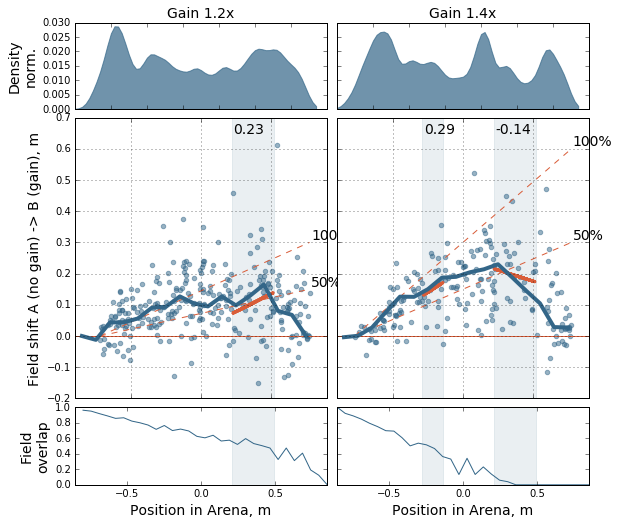

In [85]:
fig = figure(figsize=(7, 6))

k_width = 12
kernel = signal.gaussian(k_width + 1, std=(k_width + 1) / 7.2)

left, width = 0.1, 0.5
bottom, height = 0.3, 0.65
spacing = 0.02
offset = 0.5
r_scat_l = [left, bottom, width, height]
r_hist_l = [left, bottom + height + spacing, width, 0.2]
r_scat_r = [left + offset + spacing, bottom, width, height]
r_hist_r = [left + offset + spacing, bottom + height + spacing, width, 0.2]
r_pred_l = [left, 0.1, width, 0.18]
r_pred_r = [left + offset + spacing, 0.1, width, 0.18]

ax1_scat = fig.add_axes(r_scat_l)
ax1_hist = fig.add_axes(r_hist_l)
ax1_hist.tick_params(direction='in', labelbottom=False)
ax1_hist.set_title('Gain 1.2x', fontsize=14)
cvd = np.convolve(vals_12/om_12, kernel, 'same') / kernel.sum()
ax1_hist.fill_between(np.arange(len(cvd)), cvd/cvd.sum(), color=COLORS['a'], alpha=0.7)
ax1_hist.set_ylabel('Density\nnorm.', fontsize=14)
ax1_scat.set_ylabel('Field shift A (no gain) -> B (gain), m', fontsize=14)
ax1_scat.set_ylim(-0.2, 0.7)
ax1_scat.set_xlim(-0.85, 0.85)
plot_shifts(ax1_scat, shift_A_B_12, 0.3, plot_regress=True)
ax1_scat.get_xaxis().set_ticklabels([])
ax1_scat.plot(bins, mean_shifts[0], color=COLORS['a'], lw=4)  # mean shifts
ax1_pred = fig.add_axes(r_pred_l)
ax1_pred.plot(np.linspace(-0.85, 0.85, len(preds[0])), preds[0], color=COLORS['a'])
ax1_pred.set_xlabel('Position in Arena, m', fontsize=14)
ax1_pred.set_ylabel('Field\noverlap', fontsize=14)
ax1_pred.set_xlim(-0.85, 0.85)

ax2_scat = fig.add_axes(r_scat_r)
ax2_hist = fig.add_axes(r_hist_r)
ax2_hist.tick_params(direction='in', labelbottom=False)
ax2_hist.get_yaxis().set_ticklabels([])
ax2_hist.set_title('Gain 1.4x', fontsize=14)
cvd = np.convolve(vals_14/om_14, kernel, 'same') / kernel.sum()
ax2_hist.fill_between(np.arange(len(cvd)), cvd/cvd.sum(), color=COLORS['a'], alpha=0.7)
ax2_scat.set_ylim(-0.2, 0.7)
ax2_scat.set_xlim(-0.85, 0.85)
ax2_scat.get_yaxis().set_ticklabels([])
plot_shifts(ax2_scat, shift_A_B_14, 0.6, plot_regress=True)
ax2_scat.get_xaxis().set_ticklabels([])
ax2_scat.plot(bins, mean_shifts[1], color=COLORS['a'], lw=4)  # mean shifts
ax2_pred = fig.add_axes(r_pred_r)
ax2_pred.get_yaxis().set_ticklabels([])
ax2_pred.plot(np.linspace(-0.85, 0.85, len(preds[1])), preds[1], color=COLORS['a'])
ax2_pred.set_xlabel('Position in Arena, m', fontsize=14)
ax2_pred.set_xlim(-0.85, 0.85)

koeff = 0.95
l_b, r_b = 0.22, 0.52
ax1_scat.axvspan(l_b, r_b, alpha=0.1, color=COLORS['a'])
ax1_pred.axvspan(l_b*koeff, r_b*koeff, alpha=0.1, color=COLORS['a'])
ax2_scat.axvspan(l_b, r_b, alpha=0.1, color=COLORS['a'])
ax2_pred.axvspan(l_b*koeff, r_b*koeff, alpha=0.1, color=COLORS['a'])

pcs_s = (0.8 + l_b)/1.6 * 0.3  # percent conflit at start of the region
pce_s = (0.8 + r_b)/1.6 * 0.3  # percent conflit at end of the region
pxs_l = (1.6 * pcs_s) / 0.6 - 0.8
pxe_l = (1.6 * pce_s) / 0.6 - 0.8
ax2_scat.axvspan(pxs_l, pxe_l, alpha=0.1, color=COLORS['a'])
ax2_pred.axvspan(pxs_l*koeff, pxe_l*koeff, alpha=0.1, color=COLORS['a'])


#fig.tight_layout()
filename = "4e.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename),bbox_inches='tight')

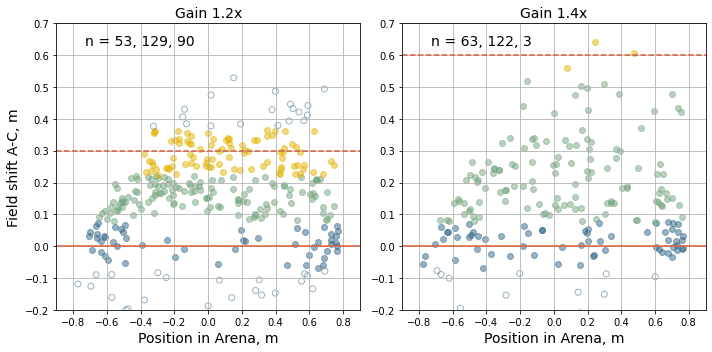

In [280]:
fig = figure(figsize=(10, 5))
titles = ['Gain 1.2x', 'Gain 1.4x']

for i, ds in enumerate([shift_A_C_12, shift_A_C_14]):
    ax = fig.add_subplot(1, 2, i+1)
    df = ds.copy()
    df['shift'] = df['shift'] * (-1)
    df = df[get_filtered_idxs(df)]
    df0 = df[(df['shift'] > -0.075) & (df['shift'] < 0.075)]
    df15 = df[(df['shift'] > 0.075) & (df['shift'] < 0.225 + i*0.3)]
    df30 = df[(df['shift'] > 0.225 + i*0.3) & (df['shift'] < 0.375 + i*0.3)]
    df_ = df[(df['shift'] < -0.075) | (df['shift'] > 0.375 + i*0.3)]
    x0, y0 = np.array(df0['COMa_y']), np.array(df0['shift'])
    x15, y15 = np.array(df15['COMa_y']), np.array(df15['shift'])
    x30, y30 = np.array(df30['COMa_y']), np.array(df30['shift'])
    x_, y_ = np.array(df_['COMa_y']), np.array(df_['shift'])        

    ax.grid()
    ax.set_ylim(-0.2, 0.7)
    ax.set_xlim(-0.9, 0.9)
    ax.axhline(0.0, color=COLORS['b'])
    ax.axhline(0.3 + i*0.3, color=COLORS['b'], ls='--')
    ax.text(-0.73, 0.63, 'n = %d, %d, %d' % (len(df0), len(df15), len(df30)), fontsize=14)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel('Position in Arena, m', fontsize=14)
    if i == 0:
        ax.set_ylabel('Field shift A-C, m', fontsize=14)

    ax.scatter(x0, y0, color=COLORS['a'], alpha=0.5)
    ax.scatter(x15, y15, color=COLORS['c'], alpha=0.5)
    ax.scatter(x30, y30, color=COLORS['d'], alpha=0.5)
    ax.scatter(x_, y_, color=COLORS['a'], alpha=0.5, facecolors='none', edgecolors=COLORS['a'])

    
fig.tight_layout()
filename = "04-vGAIN_shift_scatter_A_C.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

In [231]:
### amount of cells we can track between A-C

### shift distribution depending on the amount of conflict

# Linking place field plots

In [12]:
# link SHIFT 1.2 place field plots
filtered = [data_full_12[i] for i in idxs_12]
to_link = [(item[0], item[1], item[2], item[3]) for item in filtered]

source = '/home/andrey/storage2/andrey/data/processed'
dest_folder = '/home/andrey/storage2/andrey/data/projects/22_VFG/all_12_filtered'
create_symlinks(dest_folder, source, to_link)